# Code to create FAT2019 Preprocessed Mel-spectrogram Dataset

This is the code to create [FAT2019 Preprocessed Mel-spectrogram Dataset](https://www.kaggle.com/daisukelab/fat2019_prep_mels1).

Creating noisy set is commented out due to kernel memory restriction. You can fully run in your local environment. No GPU used.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['fat2019_prep_mels1', 'freesound-audio-tagging-2019']


In [2]:
DATA = Path('../input/freesound-audio-tagging-2019')
#PREPROCESSED = Path('../input/fat2019_prep_mels1')
PREPROCESSED = Path('work/fat2019_prep_mels1')
WORK = Path('work')
Path(PREPROCESSED).mkdir(exist_ok=True, parents=True)
Path(WORK).mkdir(exist_ok=True, parents=True)

CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

MELS_TRN_CURATED = PREPROCESSED/'mels_train_curated.pkl'
MELS_TRN_NOISY = PREPROCESSED/'mels_train_noisy.pkl'
MELS_TEST = PREPROCESSED/'mels_test.pkl'

CSV_TRN_NOISY_BEST50S = PREPROCESSED/'trn_noisy_best50s.csv'
MELS_TRN_NOISY_BEST50S = PREPROCESSED/'mels_trn_noisy_best50s.pkl'

trn_curated_df = pd.read_csv(CSV_TRN_CURATED)
trn_noisy_df = pd.read_csv(CSV_TRN_NOISY)
test_df = pd.read_csv(CSV_SUBMISSION)

In [3]:
import librosa
import librosa.display
import random

from fastai import *
from fastai.callbacks import *
from fastai.vision import *
from fastai.vision.data import *


def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    sampling_rate = 44100
    duration = 2 # sec
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration


def get_default_conf():
    return conf

    
def set_fastai_random_seed(seed=42):
    # https://docs.fast.ai/dev/test.html#getting-reproducible-results

    # python RNG
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)

In [4]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X


def save_as_pkl_binary(obj, filename):
    """Save object as pickle binary file.
    Thanks to https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    """
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_pkl(filename):
    """Load pickle object from file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
conf = get_default_conf()

def convert_dataset(df, source_folder, filename):
    X = convert_wav_to_image(df, source=source_folder)
    save_as_pkl_binary(X, filename)
    print(f'Created {filename}')
    return X

convert_dataset(trn_curated_df, TRN_CURATED, MELS_TRN_CURATED);
convert_dataset(test_df, TEST, MELS_TEST);


Created work/fat2019_prep_mels1/mels_train_curated.pkl



Created work/fat2019_prep_mels1/mels_test.pkl


## Creating Best 50s

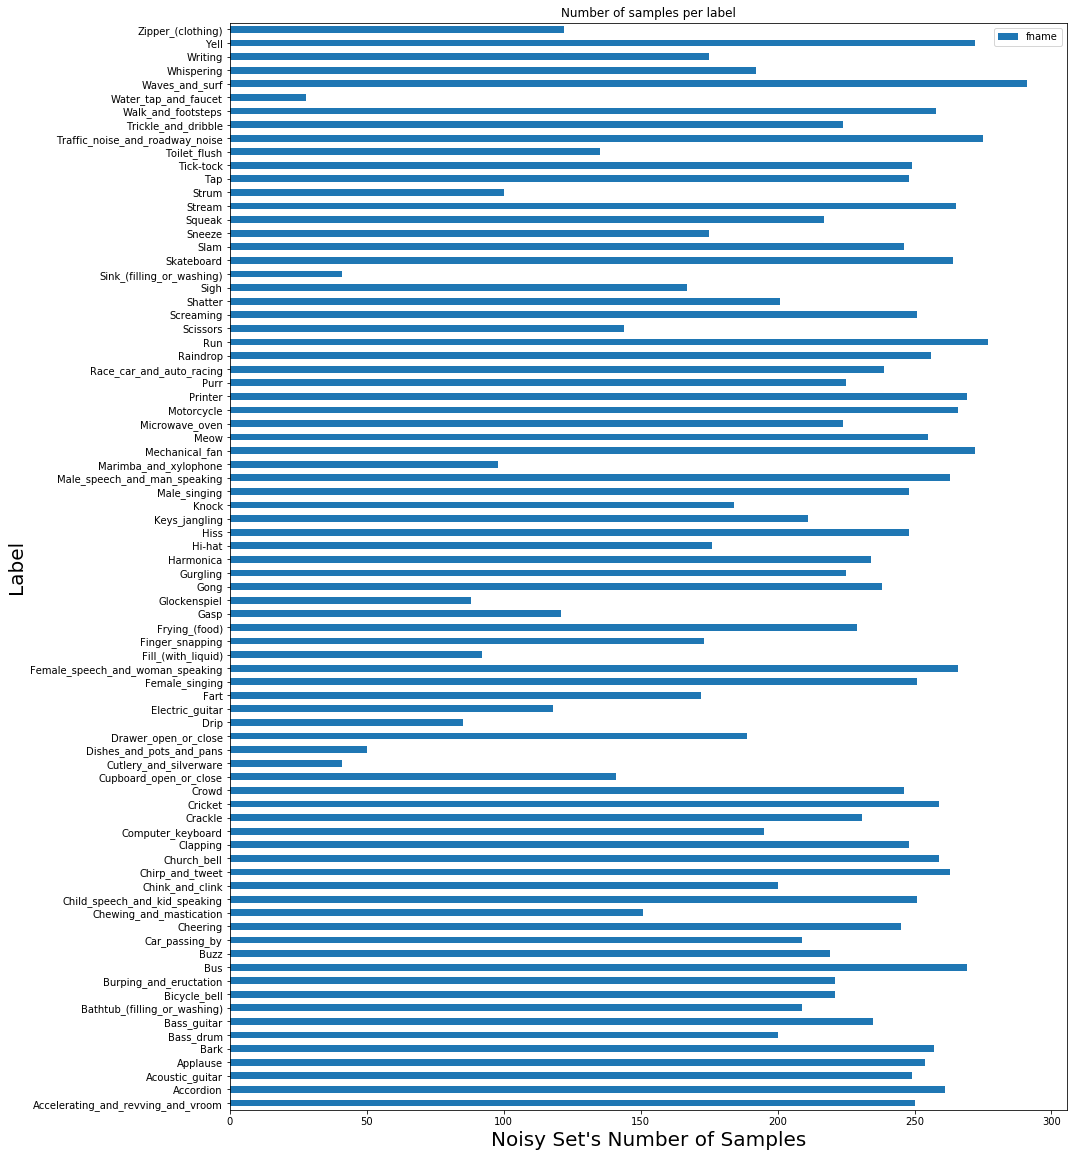

In [6]:
df = trn_noisy_df.copy()
df['singled'] = ~df.labels.str.contains(',')
singles_df = df[df.singled]

cat_gp = (singles_df.groupby(
    ['labels']).agg({
    'fname':'count'
}).reset_index()).set_index('labels')

plot = cat_gp.plot(
    kind='barh',
    title="Number of samples per label",
    figsize=(15,20))
plot.set_xlabel("Noisy Set's Number of Samples", fontsize=20)
plot.set_ylabel("Label", fontsize=20);

In [7]:
labels = singles_df.labels.unique()
labels, len(labels)

(array(['Bathtub_(filling_or_washing)', 'Motorcycle', 'Raindrop', 'Bass_guitar', ..., 'Glockenspiel',
        'Dishes_and_pots_and_pans', 'Sink_(filling_or_washing)', 'Water_tap_and_faucet'], dtype=object),
 80)

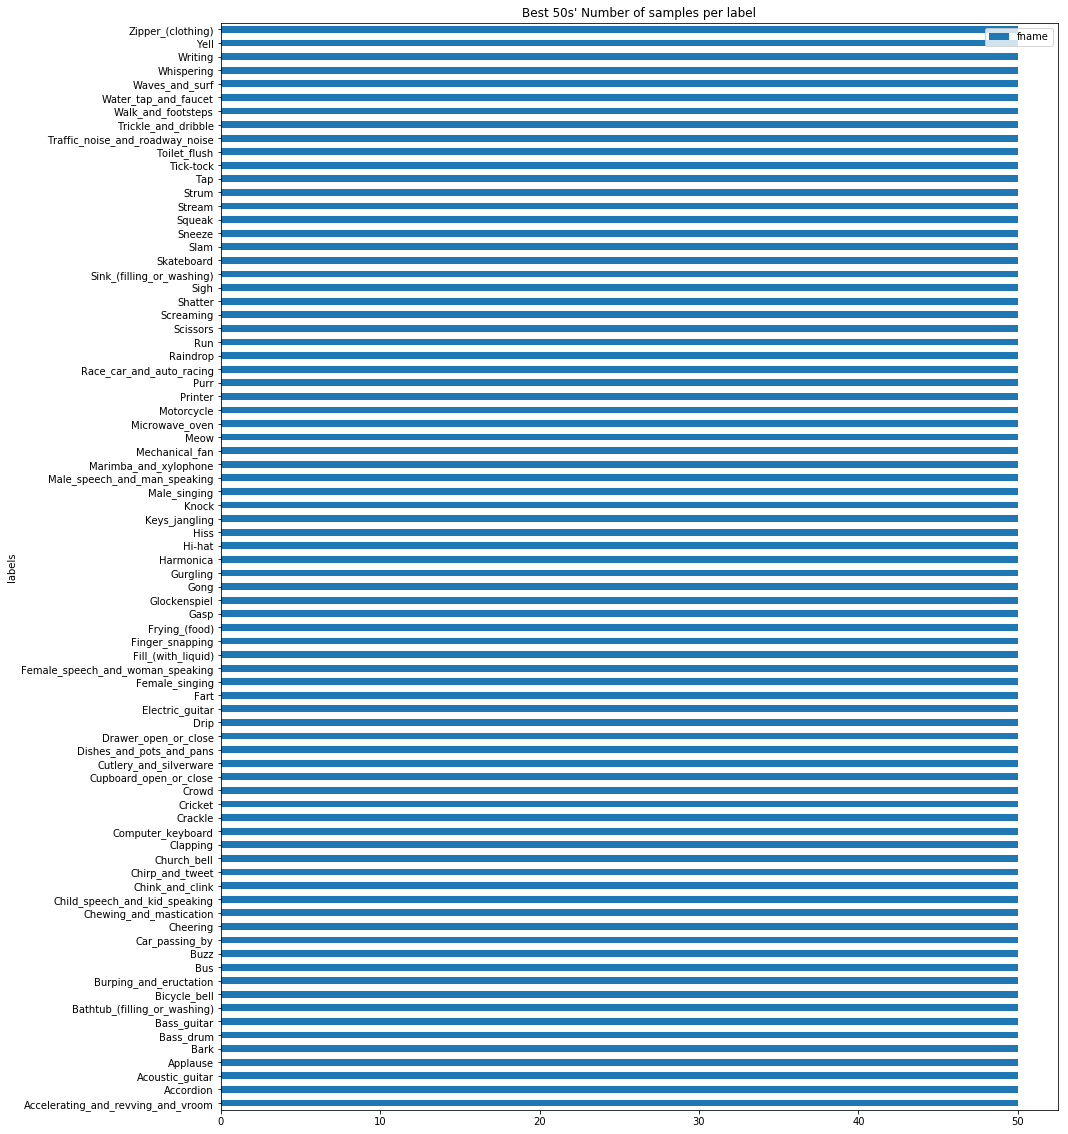

In [8]:
idxes_best50s = np.array([random.choices(singles_df[(singles_df.labels == l)].index, k=50)
                          for l in labels]).ravel()
best50s_df = singles_df.loc[idxes_best50s]

grp = (best50s_df.groupby(
    ['labels']).agg({
    'fname':'count'
}).reset_index()).set_index('labels')
grp.plot( kind='barh', title="Best 50s' Number of samples per label", figsize=(15,20));

In [9]:
best50s_df.to_csv(CSV_TRN_NOISY_BEST50S, index=False)

### Now best 50s are selected

Making preprocessed data is as follows, but you have to run locally. Kernel cannot hold all the noisy preprocessed data on memory.

In [10]:
# Convert noisy set first
#X_trn_noisy = convert_dataset(trn_noisy_df, TRN_NOISY, MELS_TRN_NOISY)

# Then choose preprocessed data for 50s, and save it
#X = [X_trn_noisy[i] for i in idxes_best50s]
#save_as_pkl_binary(X, MELS_TRN_NOISY_BEST50S)